In [112]:
import numpy as np 
import matplotlib.pyplot as plt
import copy

### Activation functions

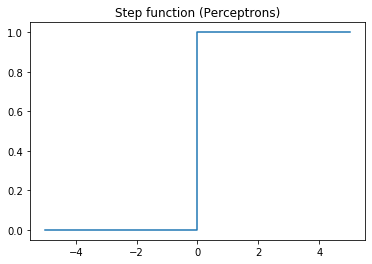

In [3]:
x = [-5,0,5] 
y = [0, 0, 1]
plt.step(x, y)
plt.title("Step function (Perceptrons)")
plt.show()

In [4]:
def sigmoid (x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

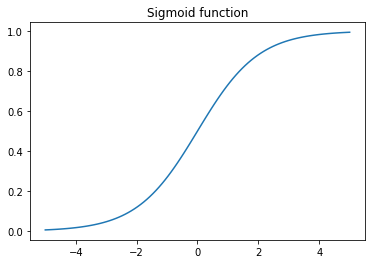

In [5]:
y = np.linspace(-5,5,100)
plt.plot(y, sigmoid(y))
plt.title("Sigmoid function")
plt.show()

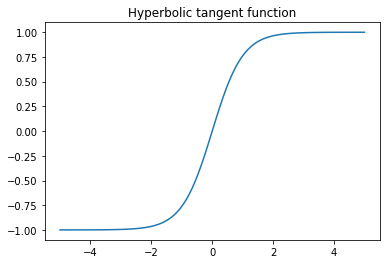

In [6]:
y = np.linspace(-5,5,100)
plt.plot(y, np.tanh(y))
plt.title("Hyperbolic tangent function")
plt.show()

In [7]:
def tanh_derivative(x):
    return 1 - (np.tanh(x))**2

In [62]:
def relu_real(x):
    return max(0,x)


def relu_derivative_real(x):
    if x<0:
        return 0
    else:
        return 1

In [133]:
def relu_list (list):
    result = copy.deepcopy(list)
    for i in range (len(result)):
        result[i] = relu_real(result[i])
    return result
        
def relu_list_derivative (list):
    result = copy.deepcopy(list)
    for i in range(len(result)):
        result[i] = relu_derivative_real(result[i])
    return result
    

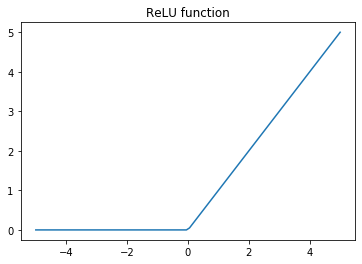

In [134]:
espace = np.linspace(-5,5,100)
plt.plot(espace, relu_list(espace))
plt.title("ReLU function")
plt.show()

In [46]:
class Activation_function(object):
    #Class used for easily choosing the activation function of the network (to be continued)
    
    def init(self, name):
        self.name = name
        if name=="sigmoid":
            self.function = sigmoid
            self.function_derivative = sigmoid_derivative
        if name=="tanh":
            self.function = np.tanh
            self.function_derivative = tanh_derivative
        if name=="relu":
            self.function = relu_list
            self.function_derivative = relu_list_derivative
            

### Network Class

In [140]:
class Network(object):
    #Class used for representing a neural network
    
    def init(self, sizes, acti): #Acti is an instance of Activation_function
        #initializing a Network object
        #sizes is a list containing the number of neurons in each layer
        np.random.seed(0)
        
        self.sizes = sizes   
        self.num_layers = len(sizes)
        self.biases = [np.array([[0],[-1]]), np.array([[0]])]
        self.weights = [np.array([[1 , 1 ], [1, 1]]), np.array([[1, -2]])]        

        #self.biases = [np.random.uniform(size=(y, 1)) for y in sizes[1:]]
        #self.weights = [np.random.uniform(size=(y, x)) for x, y in zip(sizes[:-1], sizes[1:])]
        self.activation_function = acti.function
        self.activation_derivative = acti.function_derivative
        
    def forward(self, x): # x is input
        #Returns the predicted output of the network when its input is "x"
        output = x
        for bias, weight in zip!(self.biases, self.weights):
            output = self.activation_function(np.dot(weight, output)+bias)
        return output
    
    def backprop(self, x, y):
        """Returns a tuple (nabla_biases, nabla_weights) representing the
        gradient for the cost function Cx for a single training example x. "nabla_biases" and
        "nabla_weights" are layer-by-layer lists of numpy arrays, similar
        to "self.biases" and "self.weights". y is the expected output with input x."""
        
        # initializing all partial derivatives with respect to biases and weights to 0
        nabla_biases = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        
        # forward propagation
        activation = x  # activation for the input layer = training data input x
        activations = [x] # list containing all the activations, layer by layer
        zs = [] # list to store all the z vectors (weighted inputs to neurons), layer by layer
        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(weight, activation)+bias
            zs.append(z)
            activation = self.activation_function(z)
            activations.append(activation)
            
        # backpropagation
        delta = self.cost_derivative(activations[-1], y)* self.activation_derivative(zs[-1]) # BP1: deltas of last layer
        nabla_biases[-1] = delta # BP3: partial derivatives with respect to biases for last layer
        nabla_weights[-1] = np.dot(delta, activations[-2].transpose()) # BP4: same with respect to weights for last layer
        
        # calculating partial derivatives for all other layers, backward
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.activation_derivative(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # BP2: deltas of layer l knowing those of layer l+1
            nabla_biases[-l] = delta # BP3 for layer l
            nabla_weights[-l] = np.dot(delta, activations[-l-1].transpose()) # BP4 for layer l
        return (nabla_biases, nabla_weights)

    def cost_derivative(self, output_activations, y):
        """Returns the vector of partial derivatives of Cx with respect to the output activations, 
        ie the activations of the output layer. Formula is valid for a quadratic cost function"""
        return (output_activations-y) 
    
    
    def gradient_descent_update(self, training_input, expected_output, epochs, learning_rate):
        """Updating the network's weights and biases by applying
        gradient descent using backpropagation to a single training example x.
        Later on, we will implement it for a whole training data set"""
        nabla_biases = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        
        costs = [(0.5*(expected_output - self.forward(training_input))**2)[0][0]] # list to store all the costs
        outputs = [self.forward(training_input)[0][0]] # list to store all the successive outputs
        for j in range(epochs):   
            delta_nabla_biases, delta_nabla_weights = self.backprop(training_input, expected_output)
            nabla_biases = [nb+dnb for nb, dnb in zip(nabla_biases, delta_nabla_biases)]
            nabla_weights = [nw+dnw for nw, dnw in zip(nabla_weights, delta_nabla_weights)] 
            
            # Using the updating rule for weights and biases from gradient descent learning
            self.weights = [w-(learning_rate)*nw for w, nw in zip(self.weights, nabla_weights)]
            self.biases = [b-(learning_rate)*nb for b, nb in zip(self.biases, nabla_biases)]    
            costs.append((0.5*(expected_output - self.forward(training_input))**2)[0][0])
            outputs.append(self.forward(training_input)[0][0])
            
        # Plotting the evolution of the cost function (note that cost function is the quadratic one)   
        x = np.arange(0,epochs+1,1)
        plt.plot(x, costs)
        plt.title("Evolution of the cost function throughout training")
        plt.xlabel("number of epochs of training")
        plt.ylabel("Cost function")
        plt.show()
        plt.plot(x, outputs)
        plt.title("Evolution of the network's outputs throughout training")
        plt.xlabel("number of epochs of training")
        plt.ylabel("Ouput values")
        plt.show()
        

    

### Testing and training the Network Class

La fonction d'activation est sigmoid
------------------------------------------------------------------------------------
initial biases:
[array([[ 0],
       [-1]]), array([[0]])]
initial weights:
[array([[1, 1],
       [1, 1]]), array([[ 1, -2]])]
initial network output:
[[0.43316699]]
------------------------------------------------------------------------------------


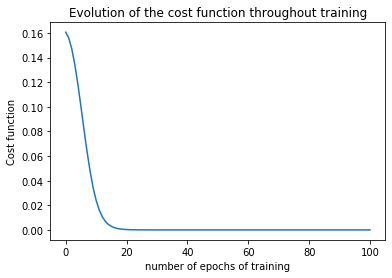

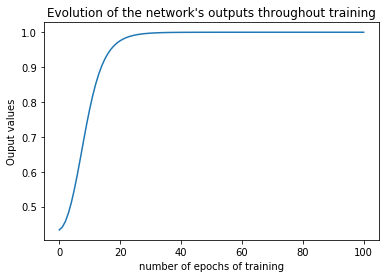

------------------------------------------------------------------------------------
final biases:
[array([[ 2.46490879],
       [-6.24480816]]), array([[11.3533847]])]
final weights:
[array([[ 1.        ,  3.46490879],
       [ 1.        , -4.24480816]]), array([[9.49447332, 3.06917315]])]
final output:
[[1.]]
------------------------------------------------------------------------------------


In [144]:
acti = Activation_function()
acti.init("sigmoid")
net = Network()
net.init([2,2,1])
net.activation_function = acti.function
net.activation_derivative = acti.function_derivative
print("La fonction d'activation est " + acti.name )
print("------------------------------------------------------------------------------------")
print("initial biases:")
print(net.biases)
print("initial weights:")
print(net.weights)
print("initial network output:")
print(net.forward(np.array([[0], [1]])))
print("------------------------------------------------------------------------------------")
net.gradient_descent_update(np.array([[0], [1]]), np.array([[1]]), 100, 0.1)
print("------------------------------------------------------------------------------------")
print("final biases:")
print(net.biases)
print("final weights:")
print(net.weights)
print("final output:")
print(net.forward(np.array([[0], [1]])))
print("------------------------------------------------------------------------------------")

In [145]:
pwd

'C:\\Users\\Nessim'